# pylift tutorial: simulated data
The folowing notebook gives a simple example of how to use the `pylift` package, on a simulated data set.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
from pylift import TransformedOutcome
from pylift.generate_data import dgp
# Generate some data.
df = dgp(N=10000, discrete_outcome=True)

/wayfair/home/ryi/venvs/default/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Basic functionality
A full-end-to-end implementation of an uplift model is shown below.

### <font color="#668b8b">Class instantiation</font>
To set up the framework for modeling, simply instantiate a `TransformedOutcome` object, specifying the data (we require a `pandas.DataFrame` as input), the treatment and outcome columns, and a few other optional parameters, if you wish.

In [3]:
# Specify your dataframe, treatment column, and outcome column.
up = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'])

### <font color="#668b8b">EDA for feature selection</font>
EDA for uplift modeling can be a bit tricky. 
We've added a couple simple methods to help with feature selection and check some basic things.

In particular, *net information value* and *net weight of evidence* can be calculated and displayed as follows (see [Data Exploration with Weight of Evidence and Information Value in R](https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/) for an overview of these concepts.

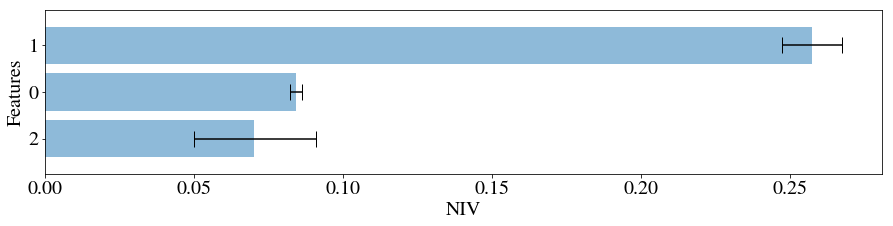

In [4]:
# This function randomly shuffles your training data set and calculates net information value.
up.NIV()

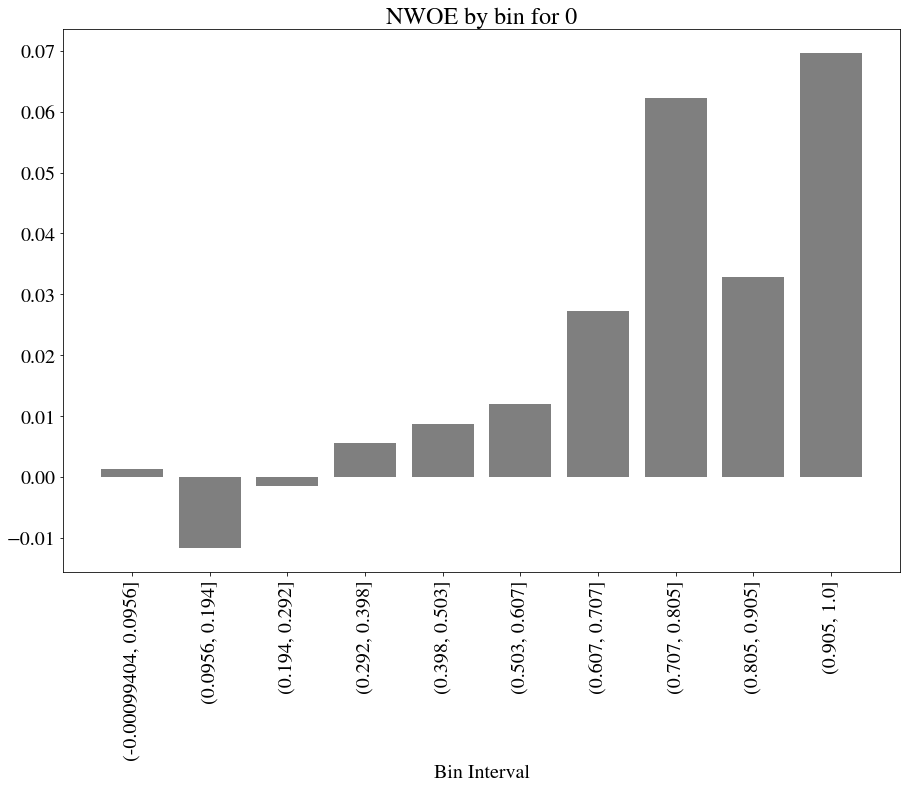

In [5]:
up.NWOE(feats_to_use=[0])

In [6]:
up.NIV_dict

{0: 0.050728533931489073, 1: 0.27021741199449784, 2: 0.064406016388114051}

### <font color="#668b8b">Hyperparameter tuning and model creation</font>

In [7]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] colsample_bytree=0.611348003135, gamma=7.20324493442, max_depth=11, min_child_weight=204, n_estimators=143, subsample=0.402729123572 
[CV] colsample_bytree=0.611348003135, gamma=7.20324493442, max_depth=11, min_child_weight=204, n_estimators=143, subsample=0.402729123572 
[CV] colsample_bytree=0.611348003135, gamma=7.20324493442, max_depth=11, min_child_weight=204, n_estimators=143, subsample=0.402729123572 
[CV] colsample_bytree=0.394892396513, gamma=1.86260211378, max_depth=15, min_child_weight=391, n_estimators=291, subsample=0.677171713802 
[CV] colsample_bytree=0.394892396513, gamma=1.86260211378, max_depth=15, min_child_weight=391, n_estimators=291, subsample=0.677171713802 
[CV] colsample_bytree=0.394892396513, gamma=1.86260211378, max_depth=15, min_child_weight=391, n_estimators=291, subsample=0.677171713802 
[CV] colsample_bytree=0.612796342936, gamma=6.85219500397, max_depth=13, min_child_weight=253, n_estimato

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.8s


[CV]  colsample_bytree=0.614071750003, gamma=9.57889530151, max_depth=5, min_child_weight=453, n_estimators=290, subsample=0.520860941704, score=0.1094294357972414, total=   0.5s
[CV] colsample_bytree=0.791000618454, gamma=8.34625671897, max_depth=15, min_child_weight=372, n_estimators=307, subsample=0.736820990534 
[CV]  colsample_bytree=0.780311673452, gamma=4.17304802367, max_depth=11, min_child_weight=242, n_estimators=488, subsample=0.438671042359, score=0.15439165931361978, total=   1.8s
[CV]  colsample_bytree=0.780311673452, gamma=4.17304802367, max_depth=11, min_child_weight=242, n_estimators=488, subsample=0.438671042359, score=0.1730056679887834, total=   2.0s
[CV]  colsample_bytree=0.614071750003, gamma=9.57889530151, max_depth=5, min_child_weight=453, n_estimators=290, subsample=0.520860941704, score=0.14168223993230616, total=   0.7s
[CV] colsample_bytree=0.791000618454, gamma=8.34625671897, max_depth=15, min_child_weight=372, n_estimators=307, subsample=0.736820990534 
[C

[CV] colsample_bytree=0.598451224657, gamma=1.65354197117, max_depth=6, min_child_weight=58, n_estimators=250, subsample=0.69970599283 
[CV]  colsample_bytree=0.68319958458, gamma=0.83623004547, max_depth=8, min_child_weight=137, n_estimators=298, subsample=0.485882661561, score=0.1436499236212163, total=   2.2s
[CV]  colsample_bytree=0.661048772854, gamma=0.533625451171, max_depth=9, min_child_weight=244, n_estimators=358, subsample=0.712513875832, score=0.07878967304996286, total=   1.9s
[CV] colsample_bytree=0.75855765604, gamma=1.26314885045, max_depth=19, min_child_weight=392, n_estimators=387, subsample=0.547757362159 
[CV]  colsample_bytree=0.661048772854, gamma=0.533625451171, max_depth=9, min_child_weight=244, n_estimators=358, subsample=0.712513875832, score=0.07056885572033886, total=   1.9s
[CV] colsample_bytree=0.75855765604, gamma=1.26314885045, max_depth=19, min_child_weight=392, n_estimators=387, subsample=0.547757362159 
[CV]  colsample_bytree=0.922083650546, gamma=5.4

[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:    8.8s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=10,
          param_distributions={'n_estimators': range(10, 500), 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, ...8524a8>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff10ed78780>},
          pre_dispatch='2*n_jobs', random_state=1, refit=False,
          return_train_score='warn', scoring=make_scorer(_aqini_sco

In [8]:
up.fit(**up.rand_search_.best_params_)

### <font color="#668b8b">Quick model evaluation</font>
Some quick model evaluation metrics are shown below. 

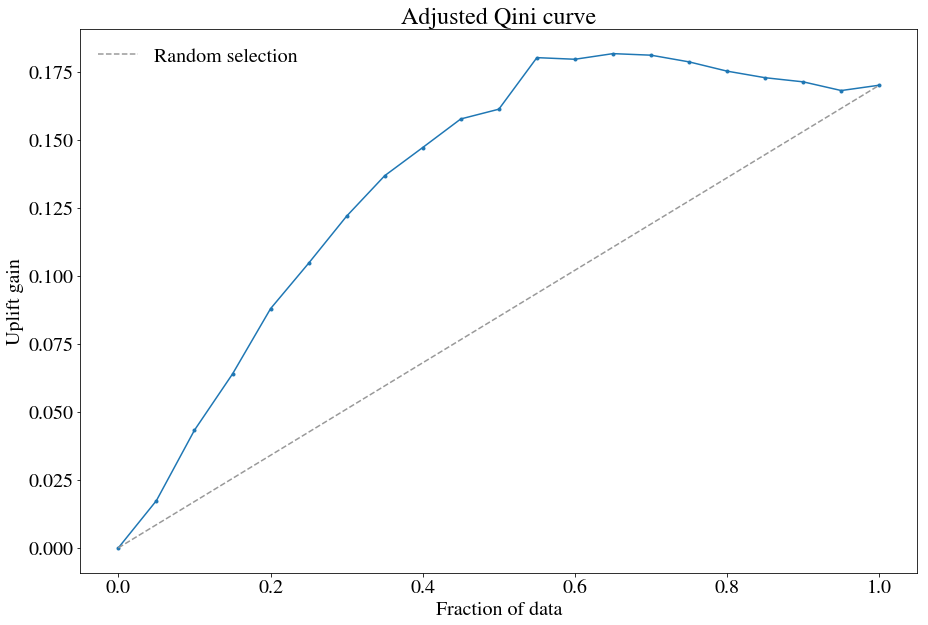

In [9]:
up.plot()

Because of the sensitivity of the Transformed Outcome method to treatment/control heterogeneities, it is generally a good idea to look at the treatment control balance. A drastically uneven (very treatment-heavy for the highest predicted uplift values) curve would suggest that your performance could improve by finding the features that carry these treatment/control bias and remove or correct them.

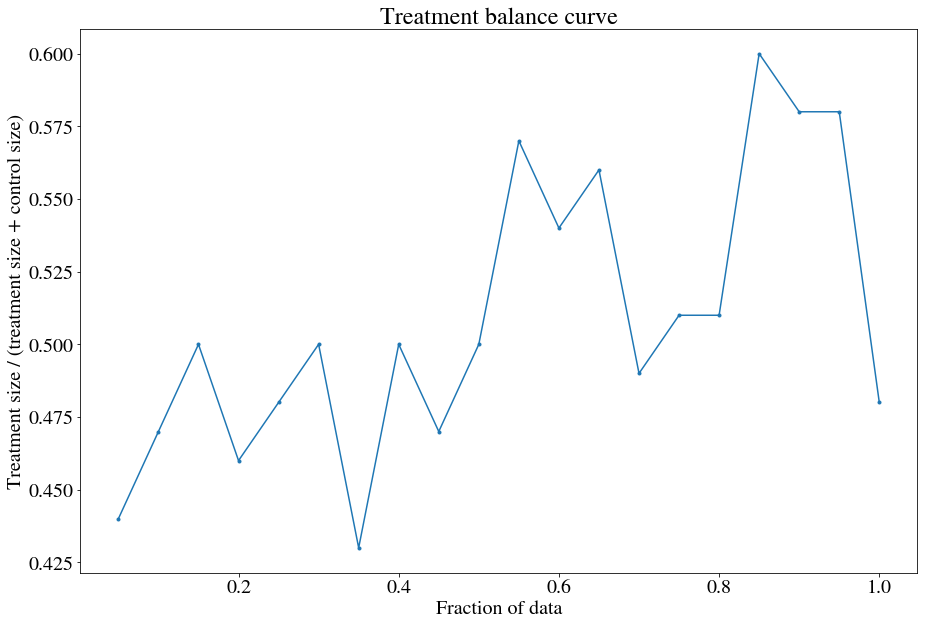

In [10]:
up.plot(plot_type='balance')

### <font color="#668b8b">Improved model evaluation</font>
It's generally pretty useful to plot error bars to get a feel for how noisy your prediction is

We implemented two ways to do this:
1. Randomly shuffling your train_test_split with a different seed, using the same hyperparameters, and plotting the resulting curves. This gives error bars around your qini curve.
1. Randomly shuffling predictions to see what you might get from fitting noise. This gives error bars around the random selection line.

In [11]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);

Seed 0 finished.
Seed 1 finished.
Seed 2 finished.
Seed 3 finished.
Seed 4 finished.


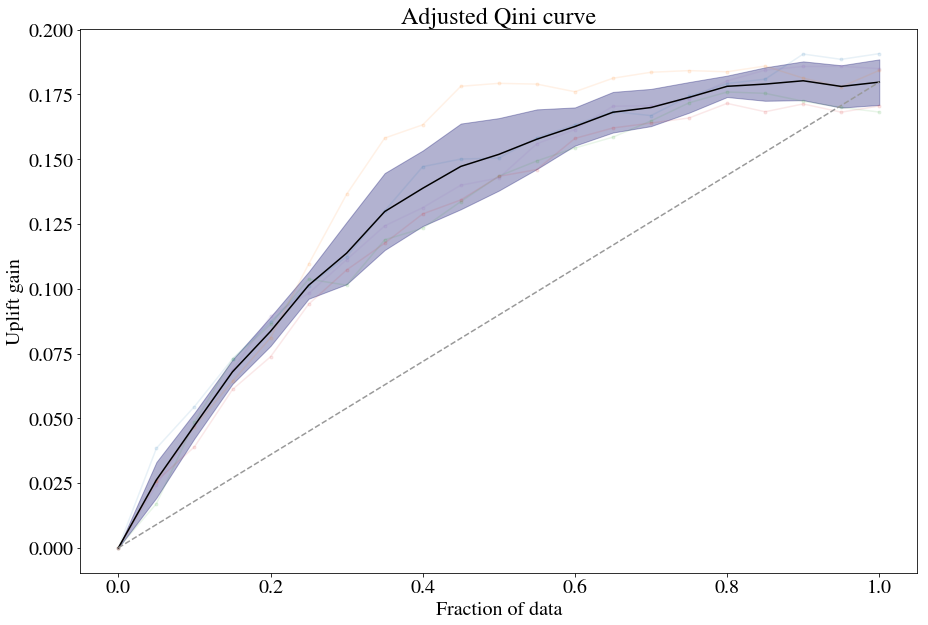

In [12]:
up.plot(show_shuffle_fits=True)

In [13]:
up.noise_fit()

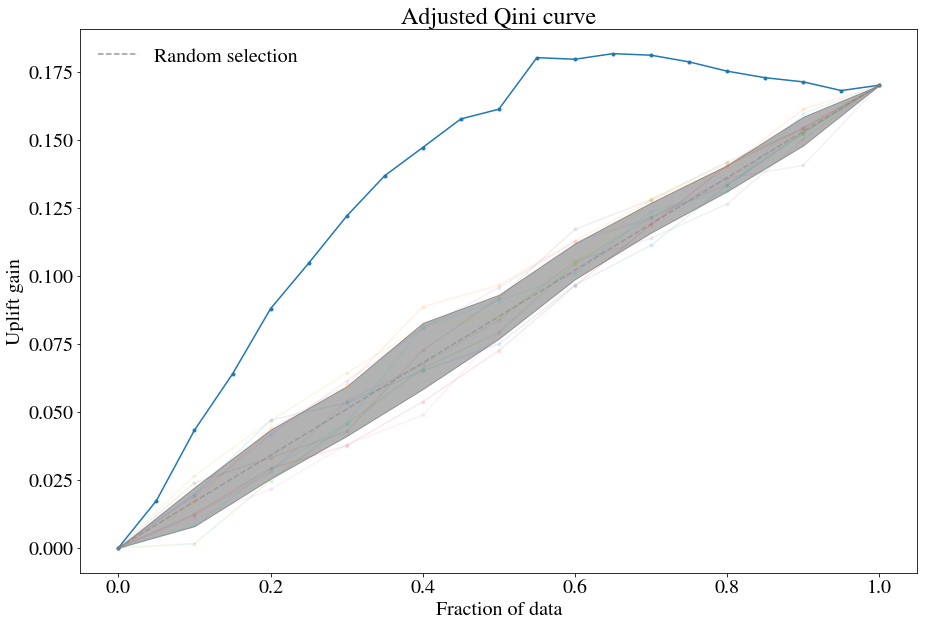

In [14]:
up.plot(show_noise_fits=True)

The colors of these plots can be adjusted by passing dictionaries which pass directly into the different components of the plot.

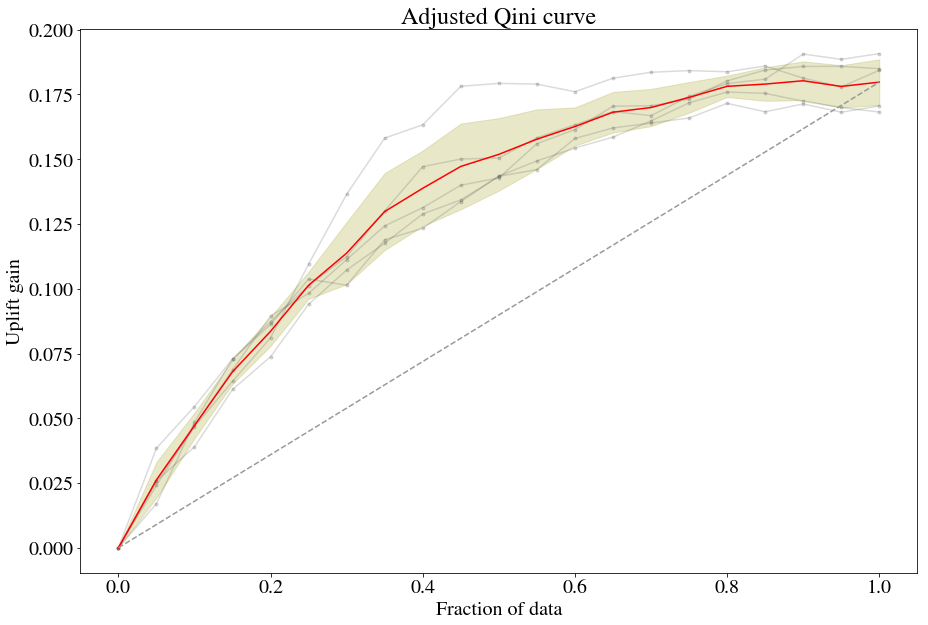

In [15]:
up.plot(plot_type='aqini',
        show_shuffle_fits=True,
        show_random_selection=True,
        shuffle_band_kwargs={'color':[0.7,0.7,0.3], 'alpha':0.3},
        shuffle_lines_kwargs={'color':[0.3,0.3,0.3], 'alpha':0.2},
        shuffle_avg_line_kwargs={'color':[1,0,0]}
       )

We can also look at the theoretical maximal curves:

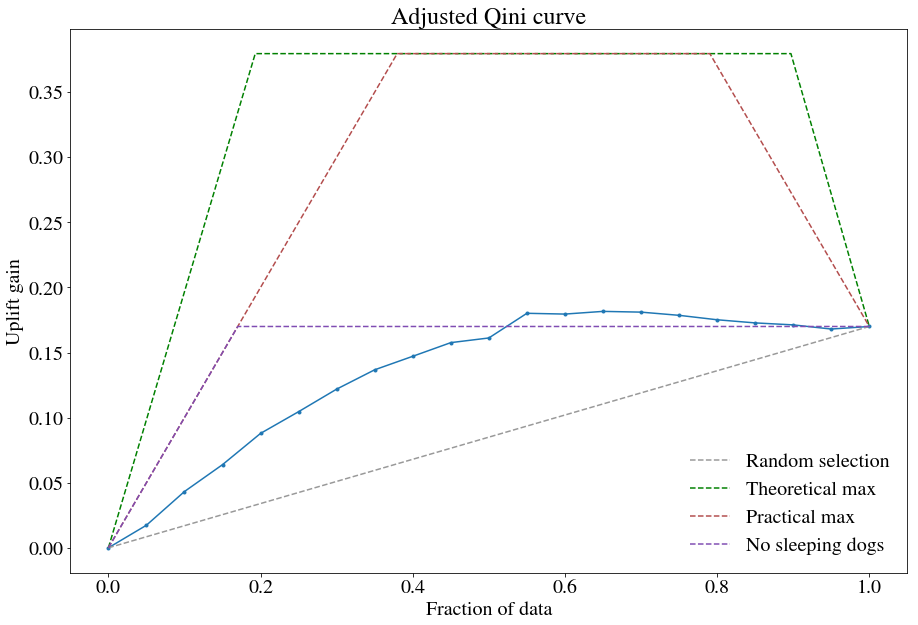

In [16]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

Finally, we can plot different kinds of curves, not just Qini curves, and these theoretical maximal options can also be plotted!

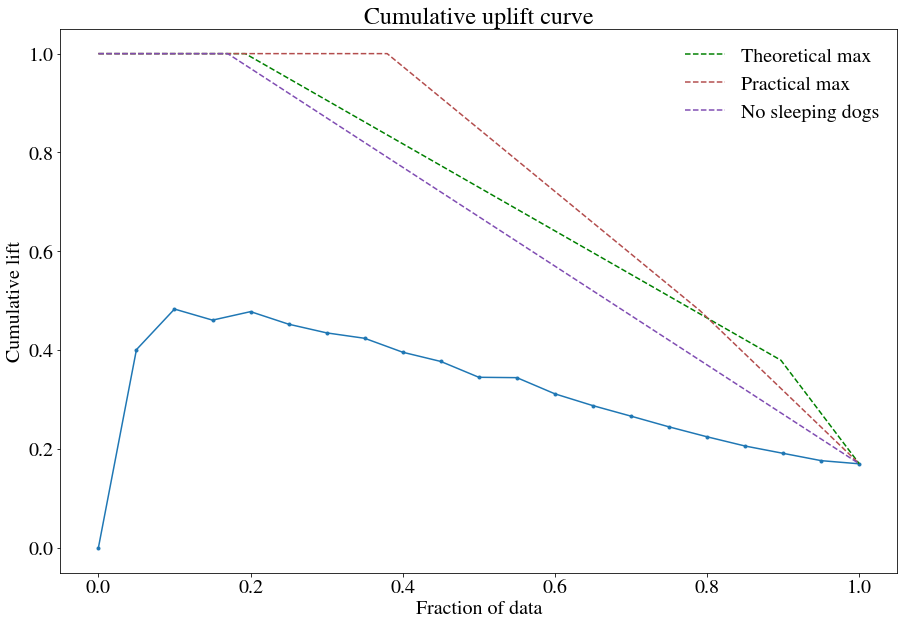

In [17]:
up.plot(plot_type='cuplift', show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

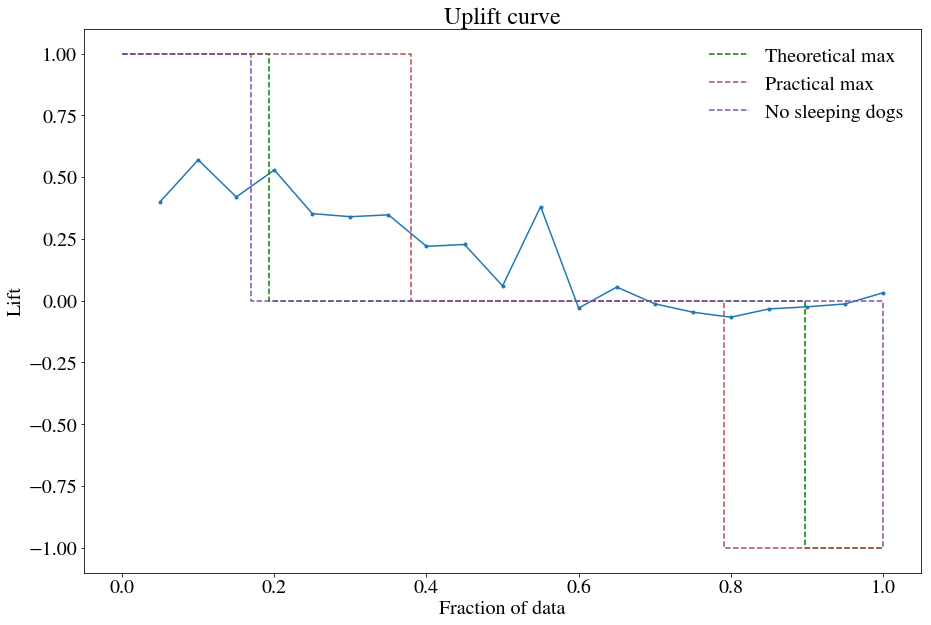

In [18]:
up.plot(plot_type='uplift', show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

These evaluation metrics by default operate on the test set, and are done so through the creation of an `UpliftEval` class object, stored in `up.test_results_`. Similar plots can be made for the training data. The data for this is actually already generated during the fitting process, and is stored in `up.train_results_`, and can be accessed by the routines therein.

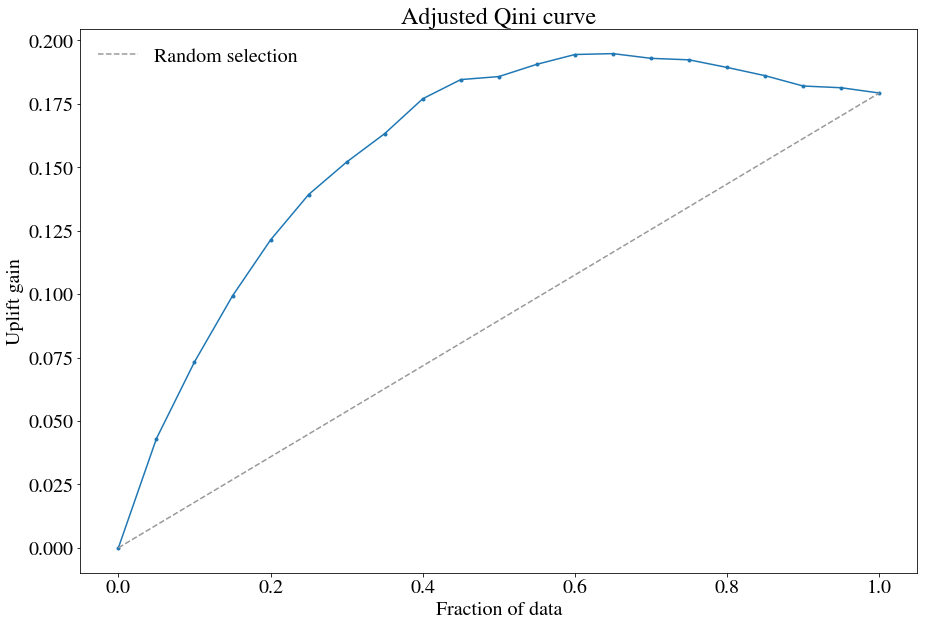

In [19]:
up.train_results_.plot()

... which is surprisingly not massively overfit!

It is also possible to get raw counts for generally anything -- for the qini curves points, the AUC scores, etc. In particular, it may be instructive to return the AUC scores for the adjusted qini curve, of which there are 3:

* `Q`: the raw AUC
* `q1`: `Q` normalized by the theoretical maximum curve.
* `q2`: `Q` normalized by the practical maximum curve.

`_aqini`, `_cgains`, or `_qini` can be appended to the above scores, which can then be accessed as class attributes within either `test_results_` or `train_results_` as follows.

In [21]:
up.test_results_.q1_aqini

0.20513559732675254

## Using multiple scoring functions
It is often useful to compare a number of different scoring metrics... At the moment, there are three scoring metrics that can be used:
* max_aqini (the maximum aqini curve value)
* qini AUC
* aqini AUC
The AUC values are currently all affected by the `scoring_cutoff` parameter. 

*This is alpha functionality and subject to change.*

The syntax is as follows, and the results are accessed a bit differently.

In [22]:
# Specify your dataframe, treatment column, and outcome column.
up = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'], scoring_method=['max_aqini', 'qini', 'aqini'], scoring_cutoff=0.4)

In [23]:
up.randomized_search(n_iter=50, n_jobs=10)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] colsample_bytree=0.379167701029, gamma=0.924920224006, max_depth=7, min_child_weight=26, n_estimators=359, subsample=0.49498366663 
[CV] colsample_bytree=0.379167701029, gamma=0.924920224006, max_depth=7, min_child_weight=26, n_estimators=359, subsample=0.49498366663 
[CV] colsample_bytree=0.379167701029, gamma=0.924920224006, max_depth=7, min_child_weight=26, n_estimators=359, subsample=0.49498366663 
[CV] colsample_bytree=0.838563719173, gamma=4.17487315722, max_depth=8, min_child_weight=12, n_estimators=220, subsample=0.582470915329 
[CV] colsample_bytree=0.838563719173, gamma=4.17487315722, max_depth=8, min_child_weight=12, n_estimators=220, subsample=0.582470915329 
[CV] colsample_bytree=0.838563719173, gamma=4.17487315722, max_depth=8, min_child_weight=12, n_estimators=220, subsample=0.582470915329 
[CV] colsample_bytree=0.46780365504, gamma=8.20876689835, max_depth=4, min_child_weight=223, n_estimators=468, subsa

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.1s


[CV] colsample_bytree=0.532244314359, gamma=4.70512233522, max_depth=17, min_child_weight=348, n_estimators=458, subsample=0.911664629892 
[CV]  colsample_bytree=0.379167701029, gamma=0.924920224006, max_depth=7, min_child_weight=26, n_estimators=359, subsample=0.49498366663, max_aqini=0.0918046001352579, qini=0.012468494466342132, aqini=0.02117611157614731, total=   2.5s
[CV] colsample_bytree=0.532244314359, gamma=4.70512233522, max_depth=17, min_child_weight=348, n_estimators=458, subsample=0.911664629892 
[CV]  colsample_bytree=0.640999047485, gamma=6.89515750795, max_depth=14, min_child_weight=151, n_estimators=190, subsample=0.821749148329, max_aqini=0.10596792858323689, qini=0.03595564534775549, aqini=0.03200691084211478, total=   1.6s
[CV]  colsample_bytree=0.379167701029, gamma=0.924920224006, max_depth=7, min_child_weight=26, n_estimators=359, subsample=0.49498366663, max_aqini=0.10374409789186671, qini=0.022938577264262884, aqini=0.023204127265850777, total=   2.9s
[CV] colsa

[CV] colsample_bytree=0.835484067882, gamma=3.54380298532, max_depth=6, min_child_weight=21, n_estimators=81, subsample=0.892807937113 
[CV]  colsample_bytree=0.61122180641, gamma=0.34690352497, max_depth=11, min_child_weight=7, n_estimators=89, subsample=0.342931473095, max_aqini=0.09199652330489881, qini=0.024647480031067478, aqini=0.027526823126089874, total=   1.0s
[CV] colsample_bytree=0.755027942127, gamma=0.649957739277, max_depth=18, min_child_weight=484, n_estimators=95, subsample=0.685210450266 
[CV]  colsample_bytree=0.842966173112, gamma=2.75106308299, max_depth=2, min_child_weight=39, n_estimators=14, subsample=0.61718512431, max_aqini=0.11722929452598066, qini=0.04239925736629183, aqini=0.03678775200272288, total=   0.5s
[CV]  colsample_bytree=0.61122180641, gamma=0.34690352497, max_depth=11, min_child_weight=7, n_estimators=89, subsample=0.342931473095, max_aqini=0.10157320754399683, qini=0.02539793196809495, aqini=0.023315396118847826, total=   0.9s
[CV]  colsample_bytr

[CV] colsample_bytree=0.661424630016, gamma=3.54304571392, max_depth=18, min_child_weight=476, n_estimators=14, subsample=0.844886936158 
[CV] colsample_bytree=0.661424630016, gamma=3.54304571392, max_depth=18, min_child_weight=476, n_estimators=14, subsample=0.844886936158 
[CV]  colsample_bytree=0.552294592637, gamma=9.77347684272, max_depth=3, min_child_weight=151, n_estimators=21, subsample=0.62448437057, max_aqini=0.1186324053286695, qini=0.035919247030495274, aqini=0.03209133284966582, total=   0.1s
[CV] colsample_bytree=0.661424630016, gamma=3.54304571392, max_depth=18, min_child_weight=476, n_estimators=14, subsample=0.844886936158 
[CV] colsample_bytree=0.542868751463, gamma=4.73524026031, max_depth=17, min_child_weight=244, n_estimators=108, subsample=0.395936821403 
[CV] colsample_bytree=0.542868751463, gamma=4.73524026031, max_depth=17, min_child_weight=244, n_estimators=108, subsample=0.395936821403 
[CV] colsample_bytree=0.542868751463, gamma=4.73524026031, max_depth=17, 

[CV] colsample_bytree=0.753480847144, gamma=5.20860923376, max_depth=18, min_child_weight=432, n_estimators=71, subsample=0.444581086324 
[CV]  colsample_bytree=0.515417807376, gamma=3.01973763432, max_depth=17, min_child_weight=41, n_estimators=151, subsample=0.618829342374, max_aqini=0.10229475871762553, qini=0.024439952621110962, aqini=0.023016983517135426, total=   2.0s
[CV] colsample_bytree=0.753480847144, gamma=5.20860923376, max_depth=18, min_child_weight=432, n_estimators=71, subsample=0.444581086324 
[CV]  colsample_bytree=0.515417807376, gamma=3.01973763432, max_depth=17, min_child_weight=41, n_estimators=151, subsample=0.618829342374, max_aqini=0.09789806346734269, qini=0.01685714240667234, aqini=0.02177304896997081, total=   2.1s
[CV] colsample_bytree=0.823010904012, gamma=4.0841759244, max_depth=16, min_child_weight=10, n_estimators=349, subsample=0.778887133883 
[CV]  colsample_bytree=0.742497227106, gamma=0.280086835953, max_depth=2, min_child_weight=171, n_estimators=11

[CV] colsample_bytree=0.72927974995, gamma=2.18978250453, max_depth=11, min_child_weight=246, n_estimators=177, subsample=0.41436879244 
[CV]  colsample_bytree=0.483272298081, gamma=7.75195841447, max_depth=10, min_child_weight=125, n_estimators=74, subsample=0.507255004136, max_aqini=0.11248256903803949, qini=0.0286081748198523, aqini=0.026333668844360916, total=   0.6s
[CV]  colsample_bytree=0.483272298081, gamma=7.75195841447, max_depth=10, min_child_weight=125, n_estimators=74, subsample=0.507255004136, max_aqini=0.10928034321005117, qini=0.035962137589565575, aqini=0.034634937194754335, total=   0.6s
[CV] colsample_bytree=0.484966547221, gamma=5.72304013561, max_depth=9, min_child_weight=167, n_estimators=237, subsample=0.380373725777 
[CV] colsample_bytree=0.484966547221, gamma=5.72304013561, max_depth=9, min_child_weight=167, n_estimators=237, subsample=0.380373725777 
[CV]  colsample_bytree=0.714035123152, gamma=0.237403379108, max_depth=19, min_child_weight=115, n_estimators=4

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   20.9s


[CV] colsample_bytree=0.404131655047, gamma=7.75434478063, max_depth=2, min_child_weight=124, n_estimators=312, subsample=0.637154372747 
[CV]  colsample_bytree=0.484966547221, gamma=5.72304013561, max_depth=9, min_child_weight=167, n_estimators=237, subsample=0.380373725777, max_aqini=0.0969786293294031, qini=0.019989359268443054, aqini=0.022021675577801877, total=   1.0s
[CV] colsample_bytree=0.404131655047, gamma=7.75434478063, max_depth=2, min_child_weight=124, n_estimators=312, subsample=0.637154372747 
[CV]  colsample_bytree=0.484966547221, gamma=5.72304013561, max_depth=9, min_child_weight=167, n_estimators=237, subsample=0.380373725777, max_aqini=0.11852760596494921, qini=0.03214290355373193, aqini=0.02820447460626982, total=   1.1s
[CV] colsample_bytree=0.553248042178, gamma=5.76202693533, max_depth=11, min_child_weight=121, n_estimators=349, subsample=0.53919043271 
[CV]  colsample_bytree=0.549527133907, gamma=0.242092927582, max_depth=8, min_child_weight=492, n_estimators=20

[CV]  colsample_bytree=0.970514500218, gamma=0.573477392831, max_depth=14, min_child_weight=391, n_estimators=48, subsample=0.84817741261, max_aqini=0.14233325245899808, qini=0.08028406432862092, aqini=0.08396777860256524, total=   0.4s
[CV]  colsample_bytree=0.357498765108, gamma=4.15459827207, max_depth=10, min_child_weight=189, n_estimators=268, subsample=0.721903219464, max_aqini=0.1034150086552181, qini=0.03231821830437011, aqini=0.02930463943995267, total=   1.1s
[CV] colsample_bytree=0.614117735473, gamma=9.26259872169, max_depth=11, min_child_weight=366, n_estimators=494, subsample=0.634365144235 
[CV]  colsample_bytree=0.970514500218, gamma=0.573477392831, max_depth=14, min_child_weight=391, n_estimators=48, subsample=0.84817741261, max_aqini=0.1472153226098058, qini=0.07235727929670362, aqini=0.06726390781046579, total=   0.5s
[CV] colsample_bytree=0.728800052404, gamma=0.0234480384141, max_depth=3, min_child_weight=88, n_estimators=458, subsample=0.668610940868 
[CV]  colsam

[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   27.1s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=10,
          param_distributions={'n_estimators': range(10, 500), 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, ...50f8d0>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff10c45a4a8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn',
          scoring={'max_aqi

In [24]:
results = up.rand_search_.cv_results_
params = results['params']

result_dict = {'max_aqini': results['mean_test_max_aqini'], 
 'qini': results['mean_test_qini'],
 'aqini': results['mean_test_aqini']}
# 'aqini': results['mean_test_aqini']}

param_dict = {}
for scorer, res in result_dict.items():
    best_idx = np.argmax(res)
    param_dict[scorer] = params[best_idx]

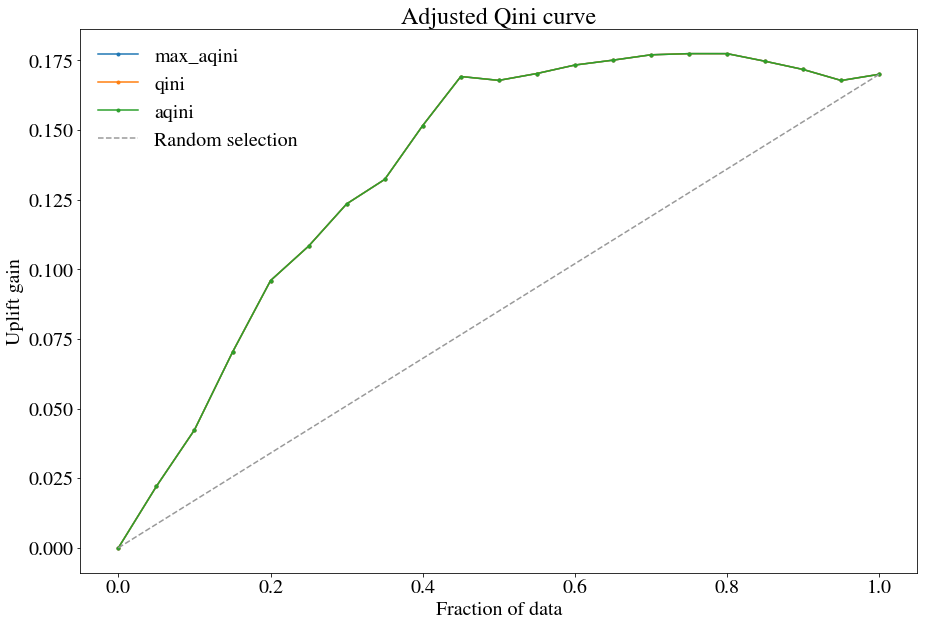

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
for keys in param_dict:
    up.fit(**param_dict[keys], nthread=30)
    up.plot(ax=ax, plot_type='aqini', label=keys, show_random_selection=keys=='aqini')

## Using a custom objective function
For xgboost in particular, it may be useful to change the objective function. Because this isn't particularly straightforward, how this can be done is shown below.

For example, if you prefer splits that find lost causes, sleeping dogs, persuadables, and sure things with an equal probability (and therefore simply splits off the purest classes), you may consider using Transformed Outcome Trees  with MAE.

In [26]:
def fair_obj(dtrain, preds):
    """y = c * abs(x) - c * np.log(abs(abs(x) + c))"""
    x = preds - dtrain
    c = 1
    den = abs(x) + c
    treat = dtrain > 0
    cont = dtrain < 0
    
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

def huber_approx_obj(dtrain, preds):
    d = dtrain - preds  #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def log_cosh_obj(dtrain, preds):
    x = preds - dtrain
    grad = np.tanh(x)
    hess = 1 / np.cosh(x)**2
    return grad, hess

In [27]:
# Specify your dataframe, treatment column, and outcome column.
upnew = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'], scoring_method='aqini', scoring_cutoff=0.4)

In [28]:
# Using MAE as the objective.
from xgboost import XGBRegressor
upnew.randomized_search_params['estimator'] = XGBRegressor(objective=log_cosh_obj, nthread=1)
upnew.randomized_search(n_iter=10, verbose=3, n_jobs=10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.341839649057, gamma=8.96334961491, max_depth=15, min_child_weight=100, n_estimators=419, subsample=0.539066375559 
[CV] colsample_bytree=0.341839649057, gamma=8.96334961491, max_depth=15, min_child_weight=100, n_estimators=419, subsample=0.539066375559 
[CV] colsample_bytree=0.341839649057, gamma=8.96334961491, max_depth=15, min_child_weight=100, n_estimators=419, subsample=0.539066375559 
[CV] colsample_bytree=0.790994136987, gamma=7.74083866319, max_depth=4, min_child_weight=94, n_estimators=275, subsample=0.980207312327 
[CV] colsample_bytree=0.790994136987, gamma=7.74083866319, max_depth=4, min_child_weight=94, n_estimators=275, subsample=0.980207312327 
[CV] colsample_bytree=0.790994136987, gamma=7.74083866319, max_depth=4, min_child_weight=94, n_estimators=275, subsample=0.980207312327 
[CV] colsample_bytree=0.627789074856, gamma=5.35734423553, max_depth=11, min_child_weight=102, n_estimators=472

[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:   14.1s remaining:    5.1s


[CV]  colsample_bytree=0.55543521976, gamma=7.76539569537, max_depth=15, min_child_weight=261, n_estimators=478, subsample=0.833851054158, score=0.020013326600383033, total=   6.1s
[CV]  colsample_bytree=0.55543521976, gamma=7.76539569537, max_depth=15, min_child_weight=261, n_estimators=478, subsample=0.833851054158, score=0.016417830900440696, total=   6.4s
[CV]  colsample_bytree=0.910973519627, gamma=5.79262666579, max_depth=6, min_child_weight=129, n_estimators=454, subsample=0.348989038573, score=0.02294243244346663, total=   6.9s
[CV]  colsample_bytree=0.55543521976, gamma=7.76539569537, max_depth=15, min_child_weight=261, n_estimators=478, subsample=0.833851054158, score=0.020951958439120396, total=   5.6s
[CV]  colsample_bytree=0.899153564728, gamma=5.96269375876, max_depth=15, min_child_weight=184, n_estimators=493, subsample=0.905642371399, score=0.013972333363523343, total=   6.1s
[CV]  colsample_bytree=0.899153564728, gamma=5.96269375876, max_depth=15, min_child_weight=184,

[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:   17.2s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
       objective=<function log_cosh_obj at 0x7ff10c2a11e0>, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=10,
          param_distributions={'n_estimators': range(10, 500), 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, ...2418d0>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff10c241b38>},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn'

In [29]:
upnew.fit(nthread=50, **upnew.rand_search_.best_params_, objective=log_cosh_obj)

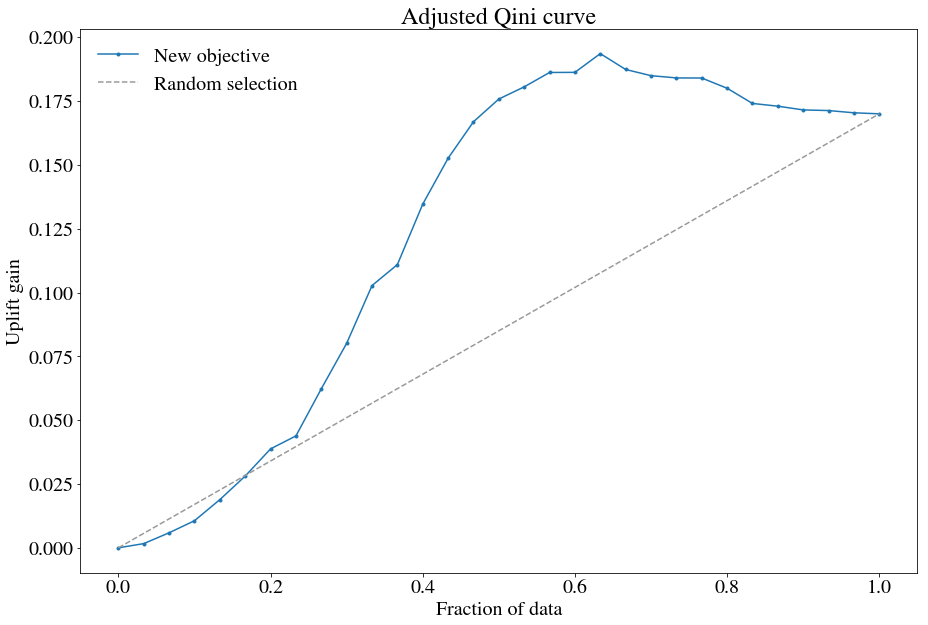

In [30]:
upnew.plot(label='New objective', n_bins=30)

... though generally in our experience, performance with such revisions is underwhelming. It may, however, be useful to note that an adaptation of the objective function could allow for **split-level corrections to uneven treatment/control proportions.** 

## Using other models
Any sklearn object can be passed to `sklearn_model` in `TransformedOutcome`, as shown below.

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
up1 = TransformedOutcome(df, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'],
                        sklearn_model=RandomForestRegressor)

In [32]:
# RandomizedSearchCV.
up1.randomized_search(param_distributions={'max_depth': range(1,100), 'min_samples_split': range(1,1000)}, n_iter=100, n_jobs=10)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] min_samples_split=135, max_depth=61 .............................
[CV] min_samples_split=135, max_depth=61 .............................
[CV] min_samples_split=135, max_depth=61 .............................
[CV] min_samples_split=881, max_depth=83 .............................
[CV] min_samples_split=881, max_depth=83 .............................
[CV] min_samples_split=881, max_depth=83 .............................
[CV]  min_samples_split=135, max_depth=61, score=0.20406130930672955, total=   0.1s
[CV] min_samples_split=413, max_depth=58 .............................
[CV] min_samples_split=413, max_depth=58 .............................
[CV] min_samples_split=373, max_depth=49 .............................
[CV]  min_samples_split=135, max_depth=61, score=0.19673897147213515, total=   0.2s
[CV] min_samples_split=373, max_depth=49 .............................
[CV] min_samples_split=413, max_depth=58 ..................

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s


[CV] min_samples_split=441, max_depth=88 .............................
[CV]  min_samples_split=876, max_depth=45, score=0.15313886534238474, total=   0.2s
[CV]  min_samples_split=512, max_depth=68, score=0.1682780988097722, total=   0.4s
[CV]  min_samples_split=876, max_depth=45, score=0.13258804517826603, total=   0.2s
[CV] min_samples_split=441, max_depth=88 .............................
[CV] min_samples_split=41, max_depth=2 ...............................
[CV] min_samples_split=41, max_depth=2 ...............................
[CV]  min_samples_split=123, max_depth=90, score=0.19717439763581449, total=   0.3s
[CV]  min_samples_split=441, max_depth=88, score=0.19093664306178812, total=   0.2s
[CV]  min_samples_split=123, max_depth=90, score=0.18112431068027693, total=   0.3s
[CV] min_samples_split=41, max_depth=2 ...............................
[CV]  min_samples_split=361, max_depth=23, score=0.1819568164152168, total=   0.4s
[CV] min_samples_split=317, max_depth=83 ..................

[CV] min_samples_split=503, max_depth=93 .............................
[CV]  min_samples_split=825, max_depth=86, score=0.126968145922094, total=   0.2s
[CV] min_samples_split=503, max_depth=93 .............................
[CV] min_samples_split=503, max_depth=93 .............................
[CV]  min_samples_split=38, max_depth=74, score=0.20180773997002555, total=   0.3s
[CV] min_samples_split=551, max_depth=27 .............................
[CV]  min_samples_split=503, max_depth=93, score=0.163963471104374, total=   0.1s
[CV]  min_samples_split=825, max_depth=86, score=0.1292278596724936, total=   0.2s
[CV] min_samples_split=551, max_depth=27 .............................
[CV]  min_samples_split=825, max_depth=86, score=0.14700996122074536, total=   0.2s
[CV]  min_samples_split=731, max_depth=77, score=0.15017053126996002, total=   0.3s
[CV] min_samples_split=551, max_depth=27 .............................
[CV]  min_samples_split=731, max_depth=77, score=0.13462871791773143, total=

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    5.4s


[CV]  min_samples_split=847, max_depth=52, score=0.13969859173330368, total=   0.2s
[CV] min_samples_split=152, max_depth=99 .............................
[CV]  min_samples_split=928, max_depth=72, score=0.12214061050153989, total=   0.1s
[CV] min_samples_split=152, max_depth=99 .............................
[CV]  min_samples_split=945, max_depth=63, score=0.12246474059568771, total=   0.2s
[CV]  min_samples_split=945, max_depth=63, score=0.1413505865262619, total=   0.2s
[CV]  min_samples_split=945, max_depth=63, score=0.12720022572514367, total=   0.3s
[CV] min_samples_split=816, max_depth=72 .............................
[CV] min_samples_split=152, max_depth=99 .............................
[CV] min_samples_split=816, max_depth=72 .............................
[CV] min_samples_split=816, max_depth=72 .............................
[CV]  min_samples_split=152, max_depth=99, score=0.19767405739572405, total=   0.1s
[CV]  min_samples_split=928, max_depth=72, score=0.15274388938855005, t

[CV]  min_samples_split=74, max_depth=4, score=0.15073876009885756, total=   0.3s
[CV]  min_samples_split=991, max_depth=63, score=0.1292730755008768, total=   0.3s
[CV]  min_samples_split=991, max_depth=63, score=0.10295288720106302, total=   0.2s
[CV] min_samples_split=961, max_depth=53 .............................
[CV] min_samples_split=961, max_depth=53 .............................
[CV]  min_samples_split=145, max_depth=21, score=0.21953971241223522, total=   0.3s
[CV] min_samples_split=836, max_depth=10 .............................
[CV]  min_samples_split=734, max_depth=3, score=0.12095221960520063, total=   0.2s
[CV] min_samples_split=836, max_depth=10 .............................
[CV]  min_samples_split=145, max_depth=21, score=0.16546547185989696, total=   0.3s
[CV] min_samples_split=836, max_depth=10 .............................
[CV]  min_samples_split=734, max_depth=3, score=0.13147417664054067, total=   0.2s
[CV]  min_samples_split=734, max_depth=3, score=0.106096592804

[CV]  min_samples_split=588, max_depth=36, score=0.16217168777165256, total=   0.3s
[CV]  min_samples_split=155, max_depth=2, score=0.1251744085063091, total=   0.1s
[CV]  min_samples_split=619, max_depth=63, score=0.17094701142779545, total=   0.1s
[CV] min_samples_split=401, max_depth=13 .............................
[CV] min_samples_split=325, max_depth=36 .............................
[CV] min_samples_split=401, max_depth=13 .............................
[CV] min_samples_split=325, max_depth=36 .............................
[CV] min_samples_split=738, max_depth=8 ..............................
[CV] min_samples_split=325, max_depth=36 .............................
[CV] min_samples_split=738, max_depth=8 ..............................
[CV]  min_samples_split=619, max_depth=63, score=0.12252091948963831, total=   0.3s
[CV]  min_samples_split=401, max_depth=13, score=0.1648427577734296, total=   0.2s
[CV]  min_samples_split=619, max_depth=63, score=0.17085627035219914, total=   0.2s
[C

[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   12.7s


[CV] min_samples_split=774, max_depth=14 .............................
[CV] min_samples_split=774, max_depth=14 .............................
[CV]  min_samples_split=329, max_depth=14, score=0.18532203354327317, total=   0.2s
[CV] min_samples_split=29, max_depth=92 ..............................
[CV] min_samples_split=29, max_depth=92 ..............................
[CV]  min_samples_split=329, max_depth=14, score=0.1879898321857558, total=   0.1s
[CV]  min_samples_split=329, max_depth=14, score=0.16551552058669852, total=   0.2s
[CV] min_samples_split=29, max_depth=92 ..............................
[CV] min_samples_split=552, max_depth=79 .............................
[CV]  min_samples_split=774, max_depth=14, score=0.14742262463109818, total=   0.1s
[CV] min_samples_split=552, max_depth=79 .............................
[CV]  min_samples_split=774, max_depth=14, score=0.15664683357018666, total=   0.1s
[CV] min_samples_split=552, max_depth=79 .............................
[CV] min_samp

[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:   14.3s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=10,
          param_distributions={'max_depth': range(1, 100), 'min_samples_split': range(1, 1000)},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn', scoring=make_scorer(_aqini_score),
          verbose=3)

In [33]:
up1.rand_search_.best_params_

{'max_depth': 92, 'min_samples_split': 29}

In [34]:
up1.fit(**up1.rand_search_.best_params_)

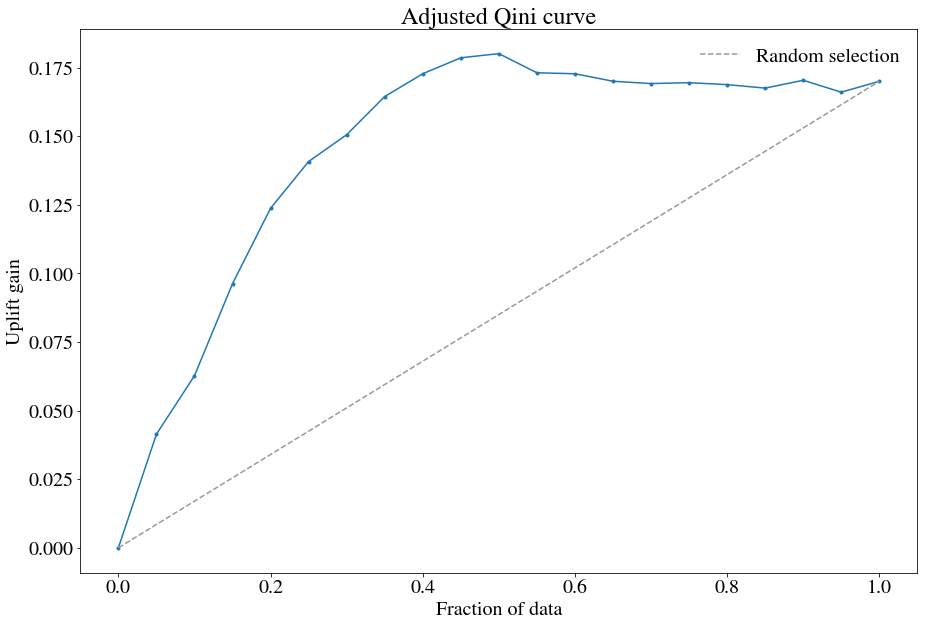

In [35]:
up1.plot()

In [36]:
up1.test_results_.q1_aqini

0.24784371530785626

In [37]:
up1.test_results_.q1_qini

0.23646393004136876

## For flexibility, all class objects are saved.

All wrapper routines save underlying class objects as class attributes, so anything you can do with sklearn you can do with this package.

In [38]:
# up.randomized_search -> up_rand_search_
up.rand_search_

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=10,
          param_distributions={'n_estimators': range(10, 500), 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, ...50f8d0>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff10c45a4a8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn',
          scoring={'max_aqi

Consequently, you can quickly go back to the **sklearn**-world you are familiar with.

Text(0.5,0,'Adjusted Qini score')

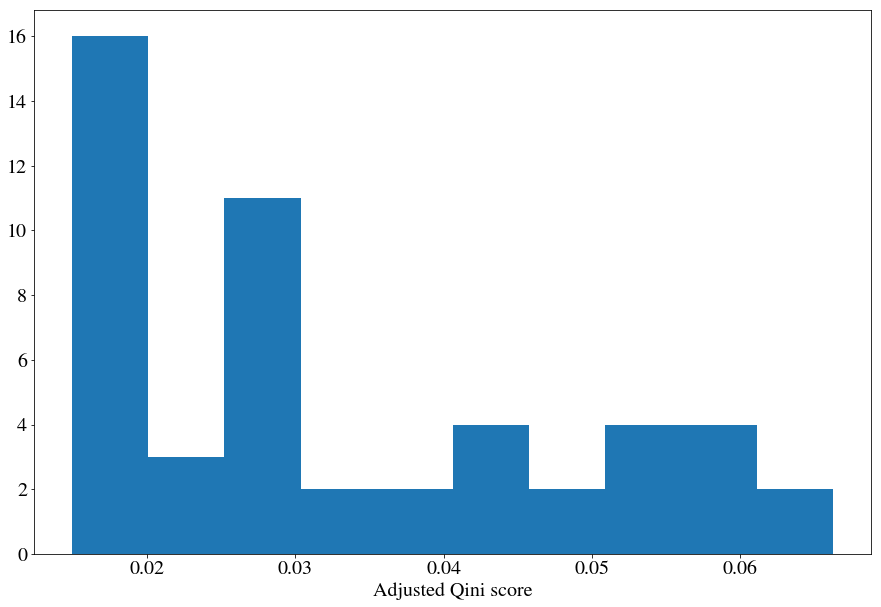

In [40]:
results = up.rand_search_.cv_results_
plt.figure(figsize=(15,10))
plt.hist(results['split0_test_aqini'], bins=10)
plt.xlabel('Adjusted Qini score')

But hopefully you don't have to, as a lot of what you might want to do in sklearn can easily be done within the context of the wrapper. E.g. below we do a linear search over one hyperparameter.

In [44]:
ranges = list(range(1,500,10))
scores = []

for val in ranges:
    up.fit(n_estimators=val, nthread=4)
    scores.append(up.test_results_.q1_aqini)

Text(0,0.5,'Adjusted q1')

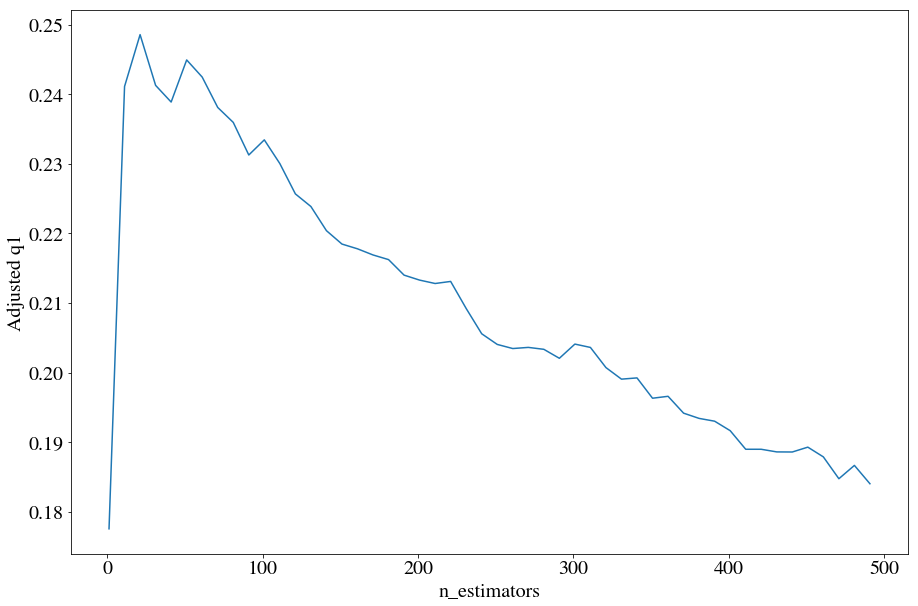

In [46]:
plt.figure(figsize=(15,10))
plt.plot(ranges, scores)

plt.xlabel('n_estimators')
plt.ylabel('Adjusted q1')

## Independent usage of evaluation metrics
If you decide pylift isn't for you, or you simply have some other methods you want to try, we also have a dedicated class `UpliftEval` to assist you in your evaluation! It simply requires your treatment, outcome, and prediction vectors as input, then automatically calculates qini-related curves, which can then be easily plotted as follows:

In [48]:
from pylift.eval import UpliftEval

In [50]:
upev = UpliftEval(up.tc_test, up.y_test, up.transformed_y_test_pred)

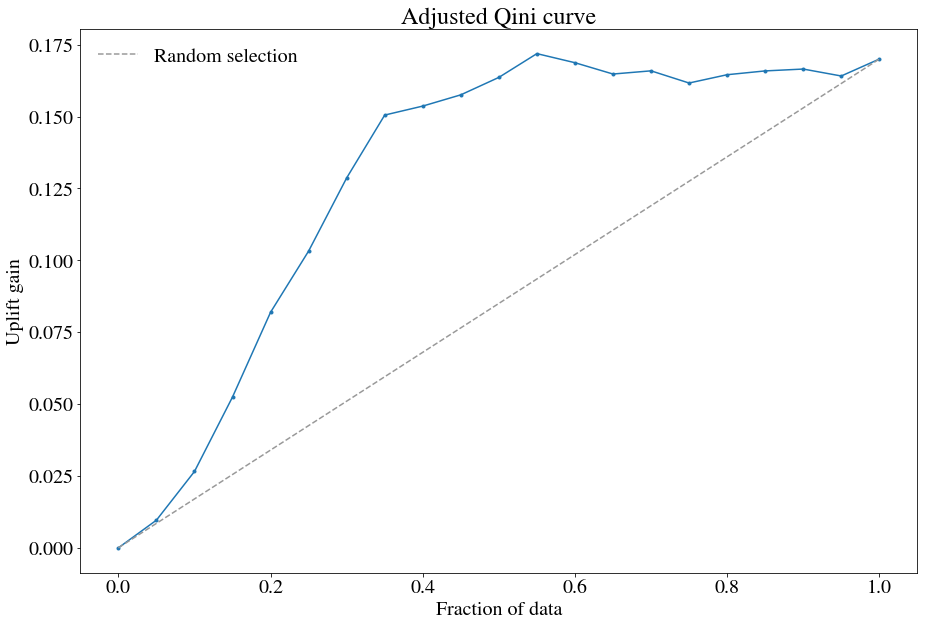

In [52]:
upev.plot()

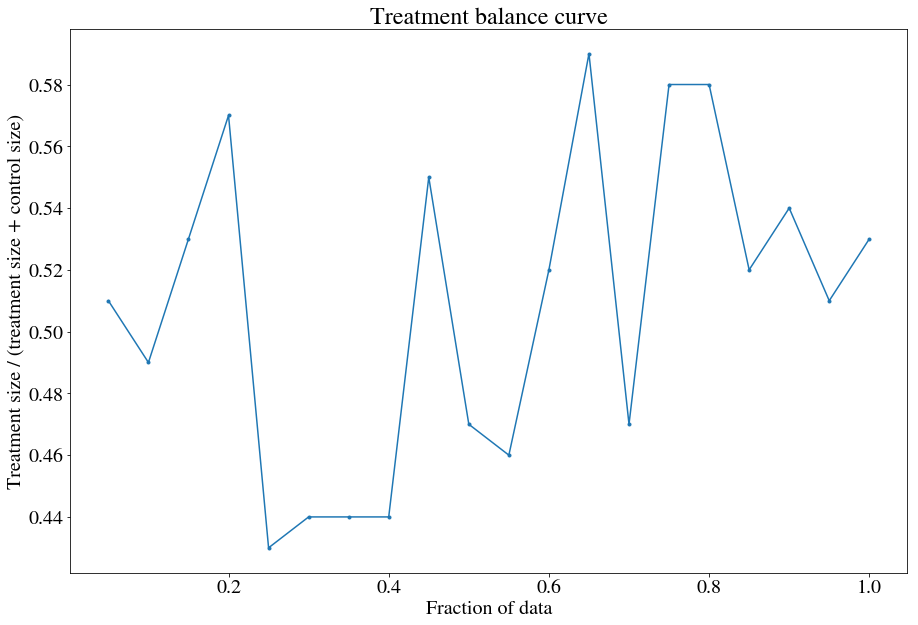

In [54]:
upev.plot(plot_type='balance')

# *<font color="#668b8b">Check docstrings (and let us know if anything is weird)!</font>*